In [1]:
import gym, time
import numpy as np

"""
TODO:
    - whyyyyy!! - it doesn't learn
    
    try
        from scipy.stats import rv_discrete
        x=[1,2,3,4]
        px=[0.1,0.4,0.2,0.3]
        sample=rv_discrete(values=(x,px)).rvs(size=10)
DONE:
- 3 version of learning:
        - current
        - current but reward squared
        - above with updating neighbours
"""

import matplotlib.pyplot as plt
%matplotlib inline

# Imports specifically so we can render outputs in Jupyter.
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display

In [2]:
class cartAgent(object):
    """Agent for CartPole-v0."""
    def __init__(self, starting_weight = 100.0):
        super(cartAgent, self).__init__()
        self.learning_precision = 100
        self.starting_weight = starting_weight
        self.x_velocity_treshold_values = np.linspace(0.01,1.0,self.learning_precision)
        self.x_velocity_treshold_weights = np.array([self.starting_weight]*self.learning_precision)
        self.angle_treshold_values = np.linspace(0.005,0.21,self.learning_precision)
        self.angle_treshold_weights = np.array([self.starting_weight]*self.learning_precision)
        self.angle_treshold_index = 0
        self.x_velocity_treshold_index = 0
        self.gen_tresholds()
        self.hist_probs = []

    def gen_tresholds(self):
        vel_probs = self.x_velocity_treshold_weights/sum(self.x_velocity_treshold_weights)
        angle_probs = self.angle_treshold_weights/sum(self.angle_treshold_weights)
        self.x_velocity_treshold_index = np.random.choice(len(self.x_velocity_treshold_values), p = vel_probs)
        self.x_velocity_treshold = self.x_velocity_treshold_values[self.x_velocity_treshold_index]
        self.angle_treshold_index = np.random.choice(len(self.angle_treshold_values), p = angle_probs)
        self.angle_treshold = self.angle_treshold_values[self.angle_treshold_index]
        return;

    def remember_probs(self):
        vel_probs = self.x_velocity_treshold_weights/sum(self.x_velocity_treshold_weights)
        angle_probs = self.angle_treshold_weights/sum(self.angle_treshold_weights)
        self.hist_probs.append( (vel_probs, angle_probs) )
        return;
    
    def get_tresholds(self):
        return self.x_velocity_treshold, self.angle_treshold

    def print_probs(self):
        print("X Velocity weights: ", self.x_velocity_treshold_weights/sum(self.x_velocity_treshold_weights))
        print("Angle weights: ", self.angle_treshold_weights/sum(self.angle_treshold_weights))

    def learn(self, reward, f = lambda x: x):
        self.x_velocity_treshold_weights[self.x_velocity_treshold_index] += f(reward)
        self.angle_treshold_weights[self.angle_treshold_index] += f(reward)
        self.gen_tresholds()

    def learn_fuzzy(self, reward, f = lambda x: x, fuzziness = 3):
        low_index = max(0, self.x_velocity_treshold_index - fuzziness)
        high_index = min(len(self.x_velocity_treshold_weights), self.x_velocity_treshold_index + fuzziness)
        self.x_velocity_treshold_weights *= 0.99
        self.angle_treshold_weights *= 0.99
        for i in range(low_index, high_index):
            diff = abs(self.x_velocity_treshold_index - i)+1
            self.x_velocity_treshold_weights[i] += f(reward)/diff
            self.angle_treshold_weights[i] += f(reward)/diff
        self.gen_tresholds()

    def makeDecision(self, observation):
        if abs(observation[1]) < self.x_velocity_treshold:
            if abs(observation[2]) < self.angle_treshold:
                action = 0 if observation[3] < 0 else 1
            else:
                action = 0 if observation[2] < 0 else 1
        else: # x velocity
            action = 1 if observation[1] < 0 else 0
        return action

def simulate(env, agent, render = False, should_print = False):
    if render:
        frames = []
    observation = env.reset()
    cumulative_reward = 0
    for t in range(200):
        if render:
            # env.render()
            frames.append(env.render(mode = 'rgb_array'))
        action = agent.makeDecision(observation)
        observation, reward, done, info = env.step(action)
        cumulative_reward += reward
        if should_print:
            print(observation)
        if done:
            break
    if render:
        env.render(close=True)
        display_frames_as_gif(frames)
    return cumulative_reward, t+1, observation

def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    #plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    display(display_animation(anim, default_mode='loop'))


In [55]:

envir = gym.make('CartPole-v0')
cart = cartAgent()
for episode in range(1000):
    cumulative_reward, time, observation = simulate(envir, cart)
    cart.learn(cumulative_reward)
    vel_tresh, angle_tresh = cart.get_tresholds()
    if episode % 50 == 0:
        print("Episode: {:3}, cumulative reward: {:4.0f}, timesteps: {:3}, last observation: {}, v_tresh: {:0.4f}, a_tresh: {:0.4f}".format(episode, cumulative_reward, time, observation, vel_tresh, angle_tresh))
    if episode % 100 == 0:
        cart.remember_probs()


Episode:   0, cumulative reward:  154, timesteps: 154, last observation: [ 0.73426165  0.70136599  0.22706342  0.66936197], v_tresh: 0.3900, a_tresh: 0.0671
Episode:  50, cumulative reward:  200, timesteps: 200, last observation: [-0.95122078 -0.39414635  0.00971465  0.13391963], v_tresh: 0.9900, a_tresh: 0.0506
Episode: 100, cumulative reward:  173, timesteps: 173, last observation: [ 0.47913971  0.48789774  0.21600669  0.69764706], v_tresh: 0.8000, a_tresh: 0.0899
Episode: 150, cumulative reward:   78, timesteps:  78, last observation: [ 0.11023298 -0.02290578  0.21443591  0.99607539], v_tresh: 0.1000, a_tresh: 0.1707
Episode: 200, cumulative reward:   67, timesteps:  67, last observation: [ 0.20606405  0.1310583   0.21678089  0.98838156], v_tresh: 0.8000, a_tresh: 0.0236
Episode: 250, cumulative reward:  200, timesteps: 200, last observation: [-0.78165119 -0.76190266 -0.05207856 -0.15257992], v_tresh: 0.9200, a_tresh: 0.0298
Episode: 300, cumulative reward:  200, timesteps: 200, las


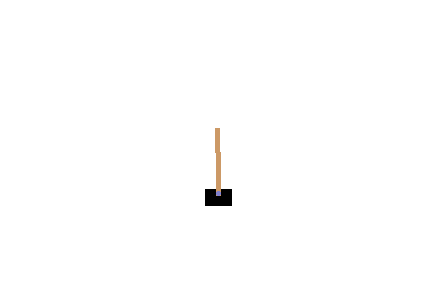
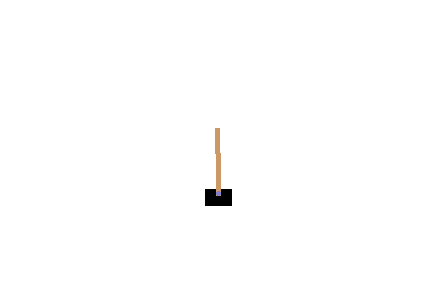
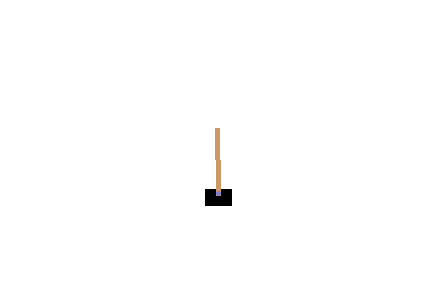
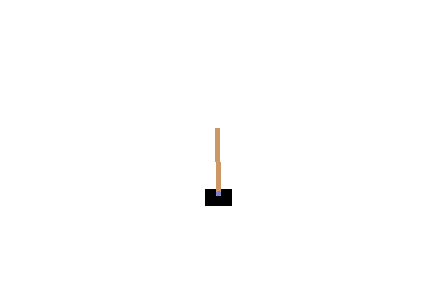
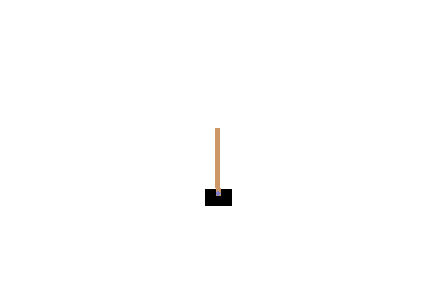
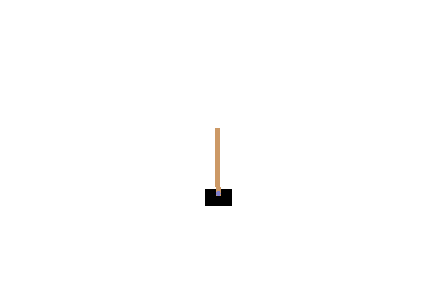
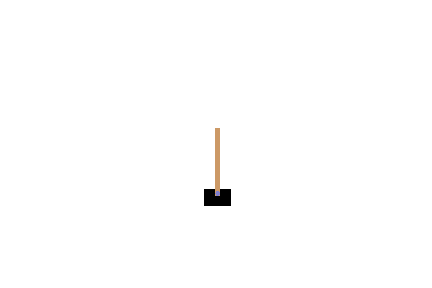
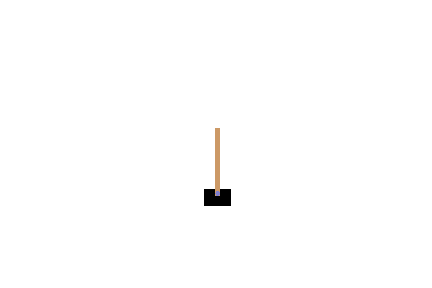
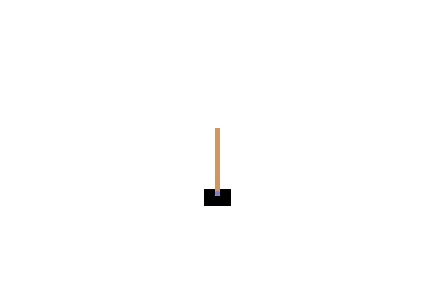
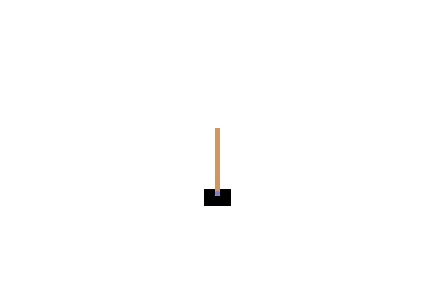
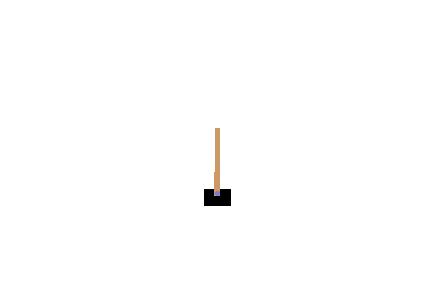
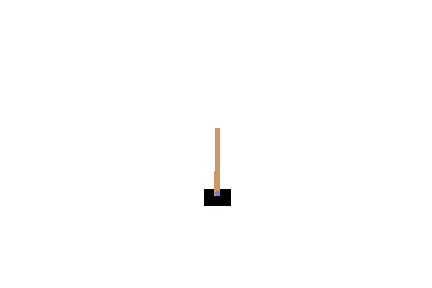
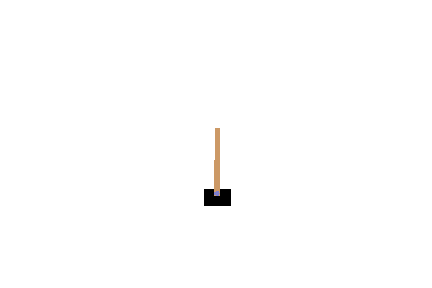
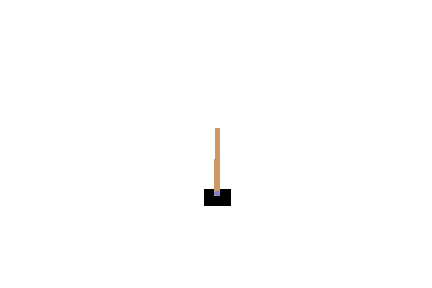
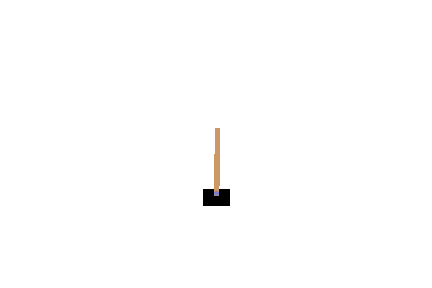
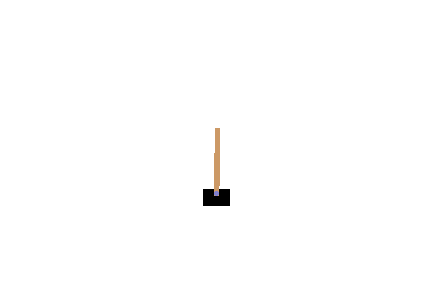
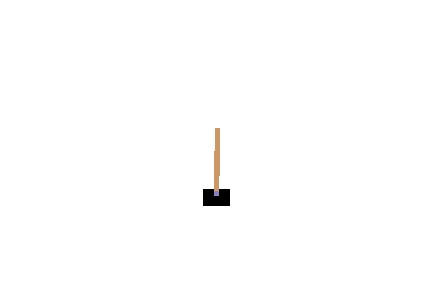
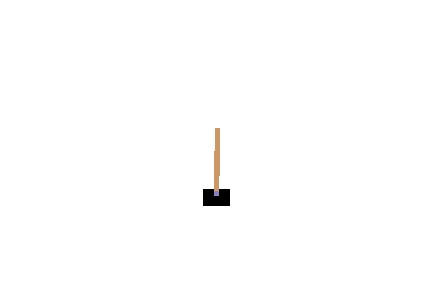
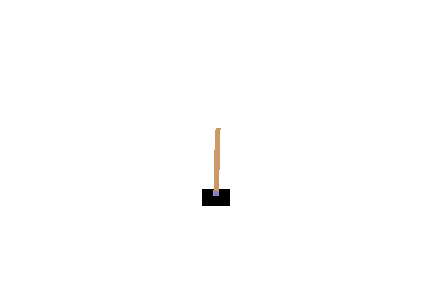
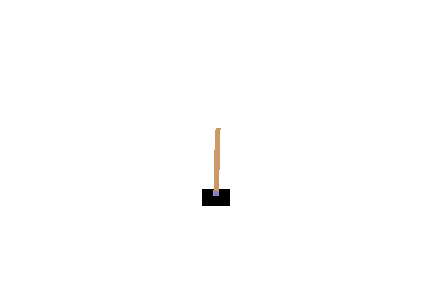
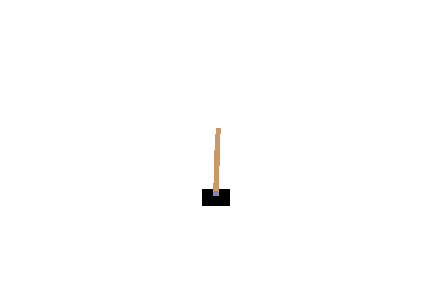
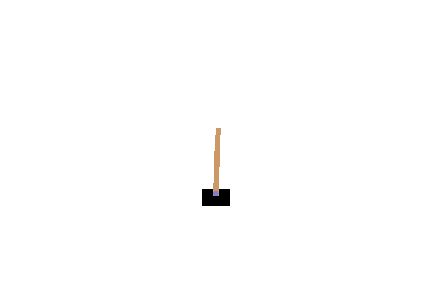
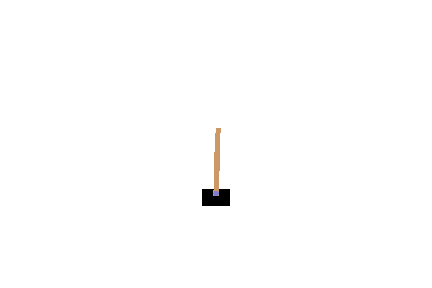
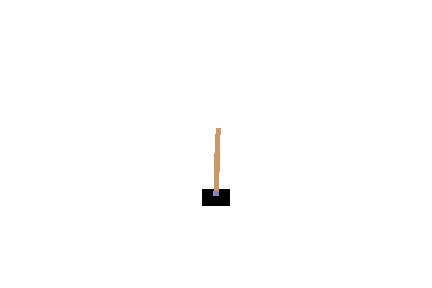
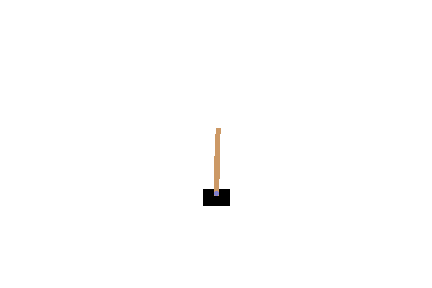
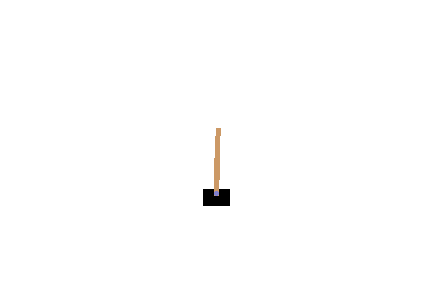
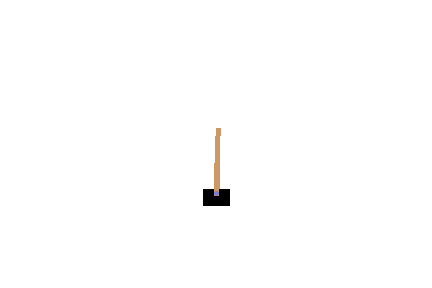
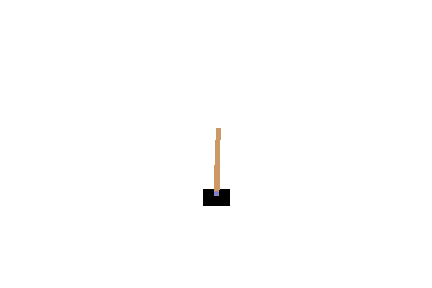
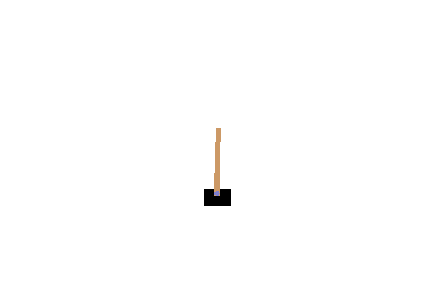
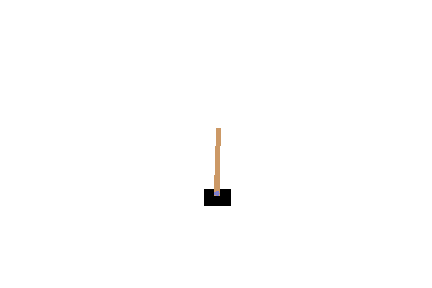
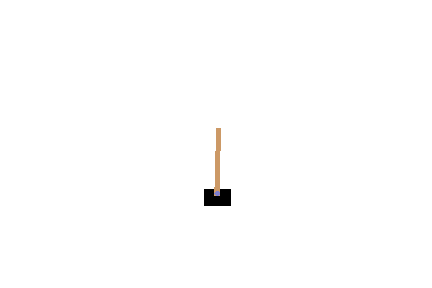
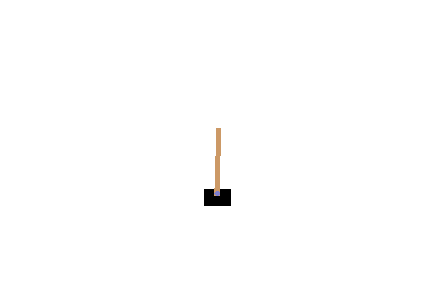
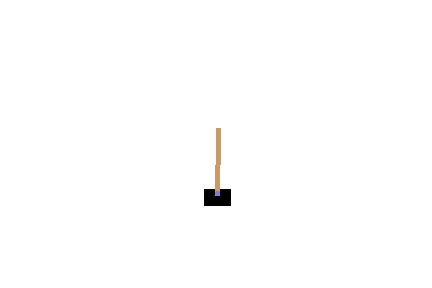
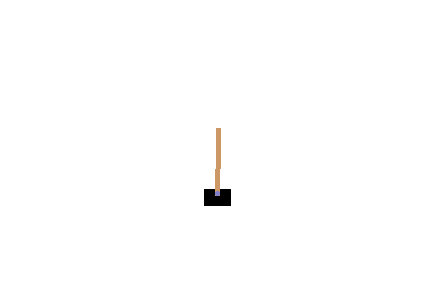
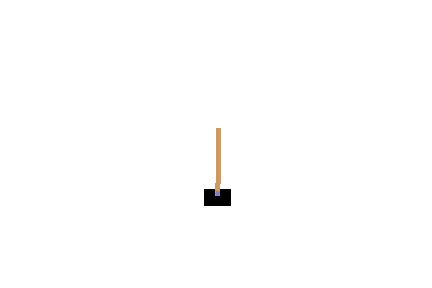
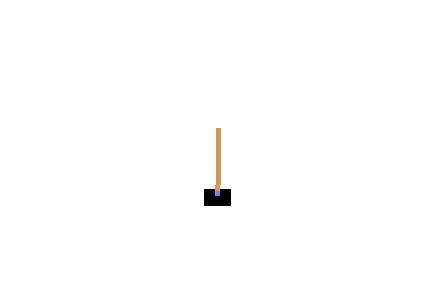
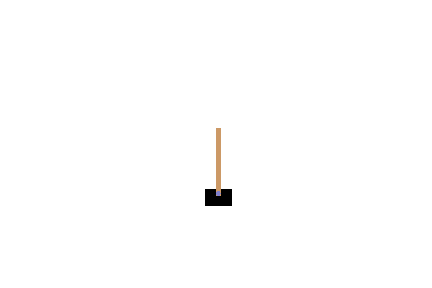
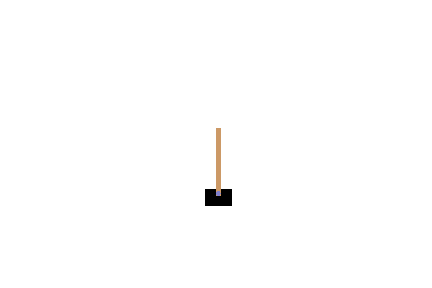
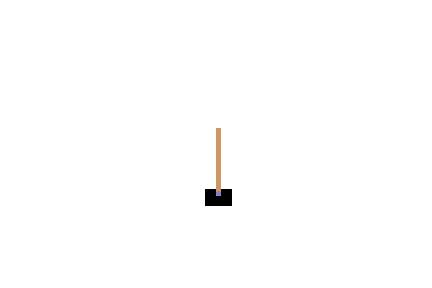
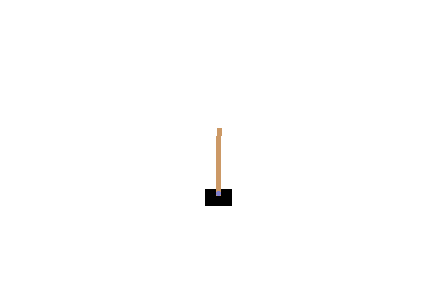
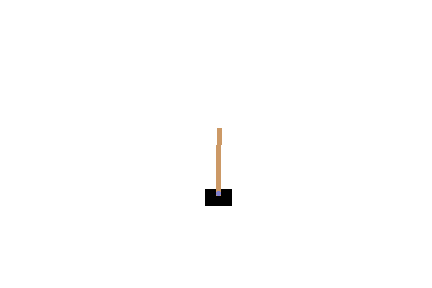
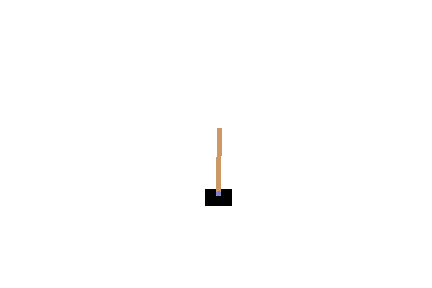
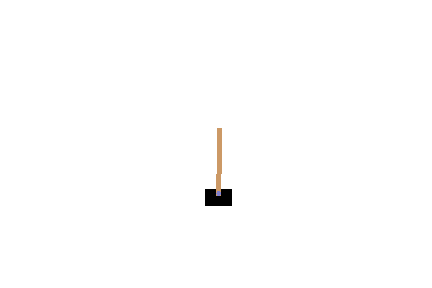
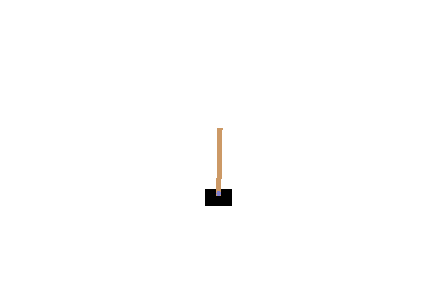
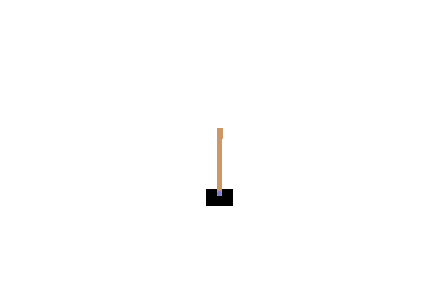
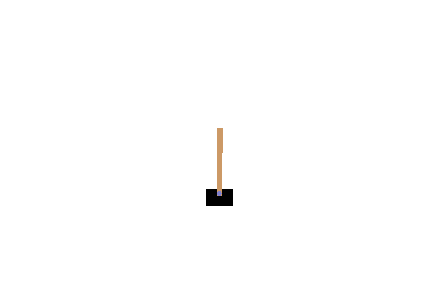
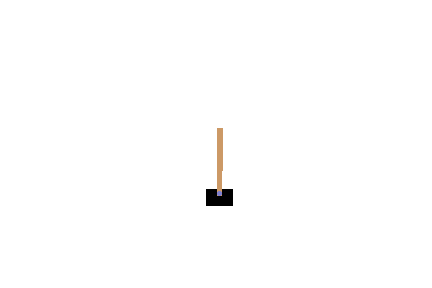
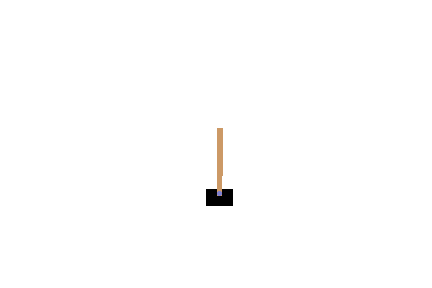
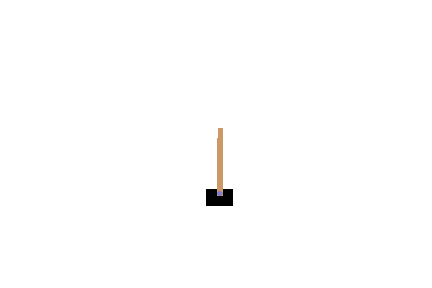
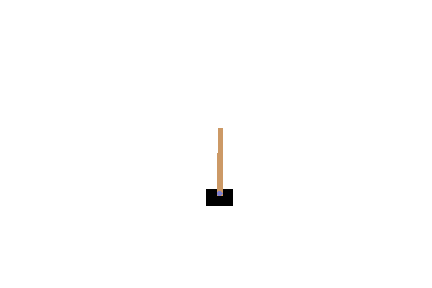
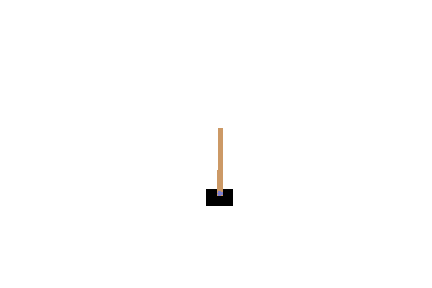
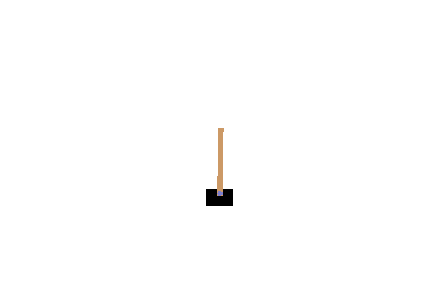
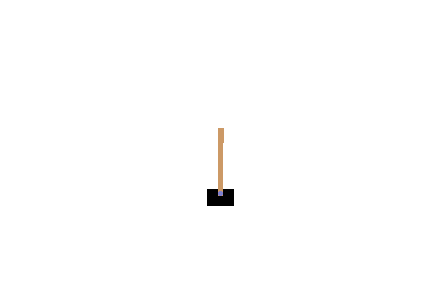
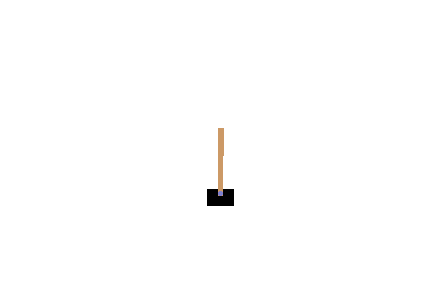
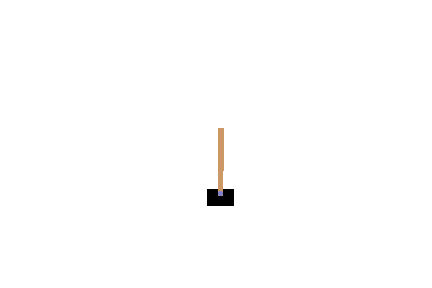
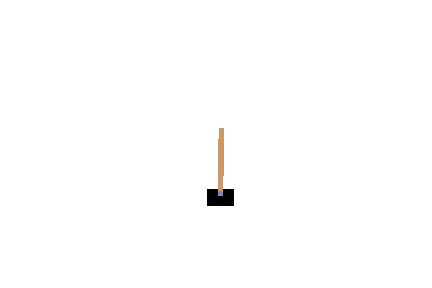
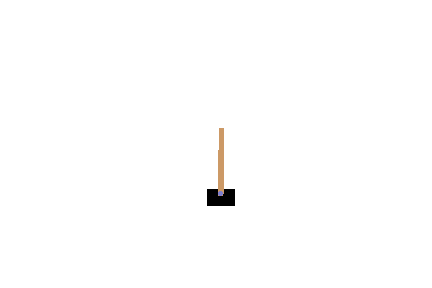
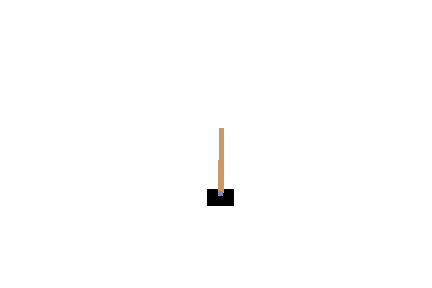
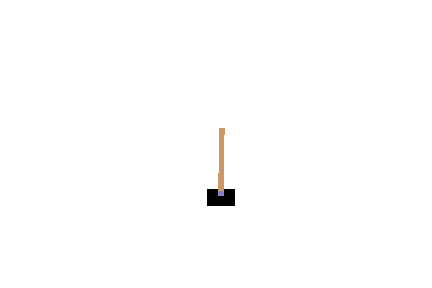
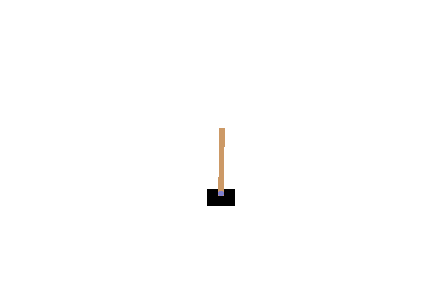
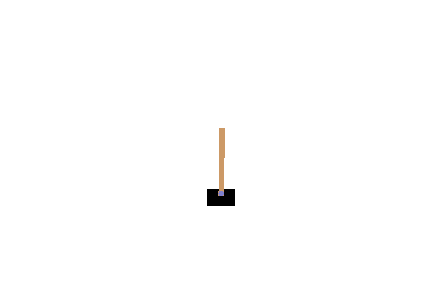
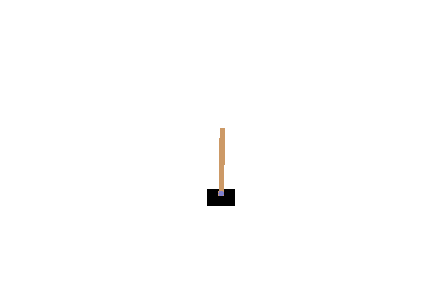
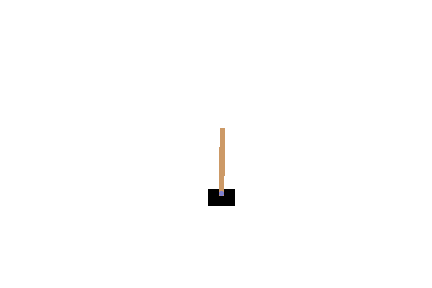
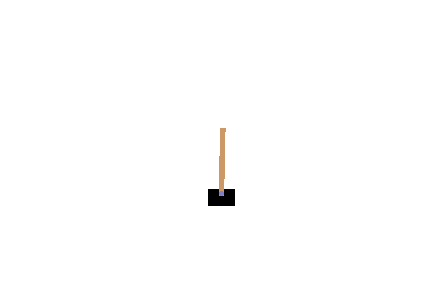
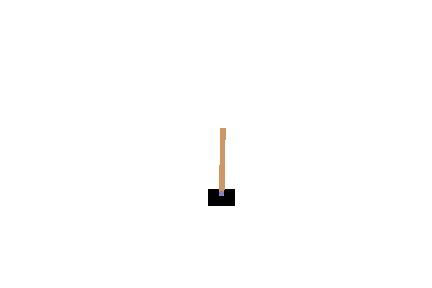
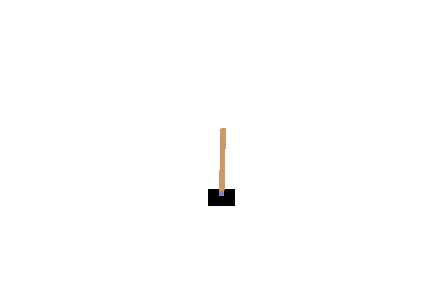
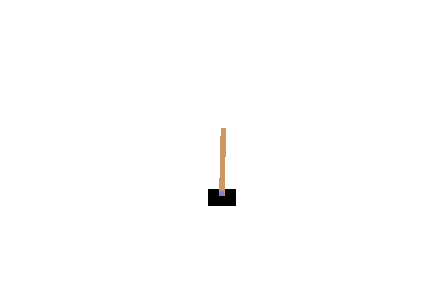
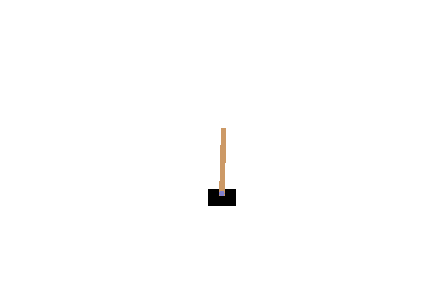
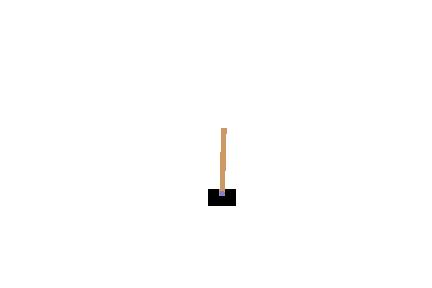
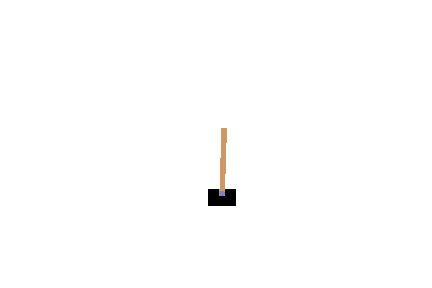
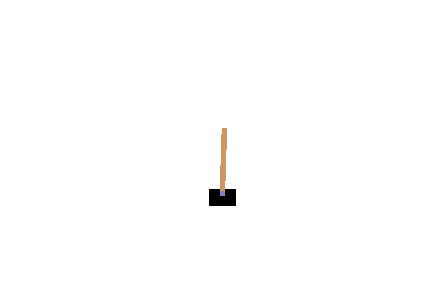
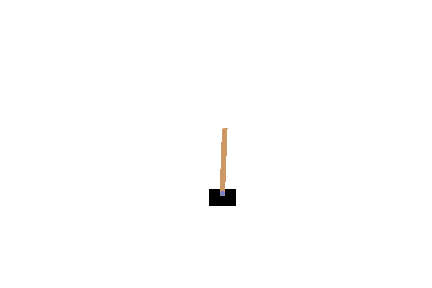
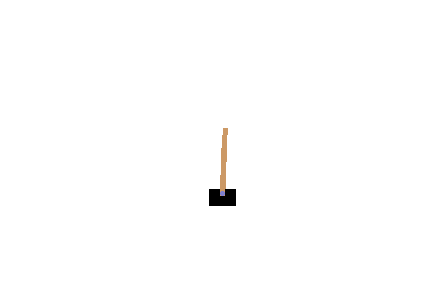
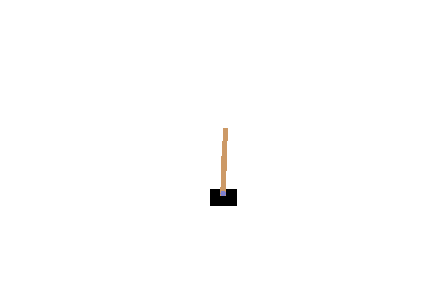
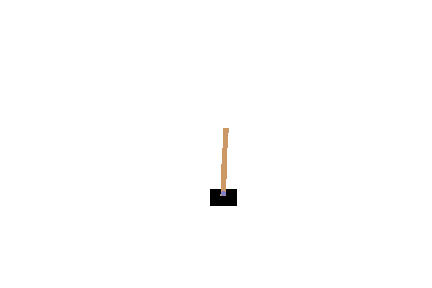
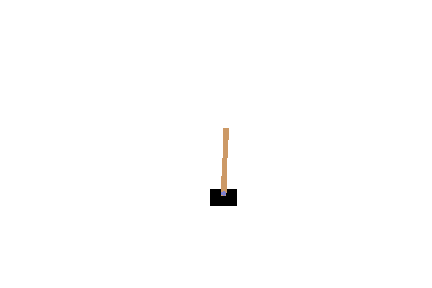
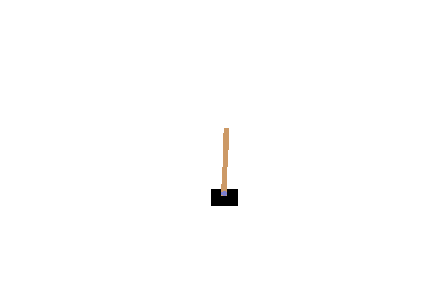
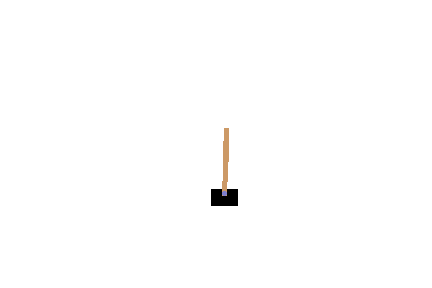
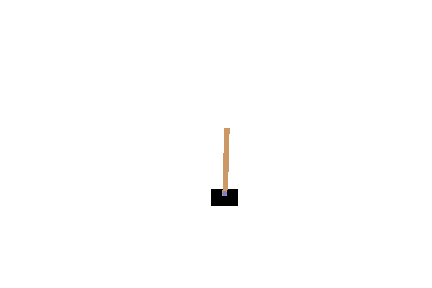
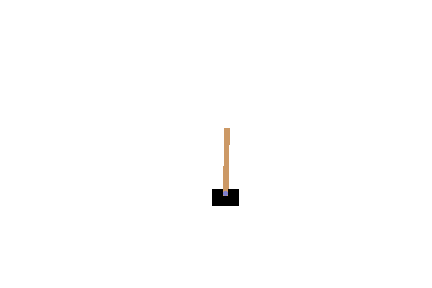
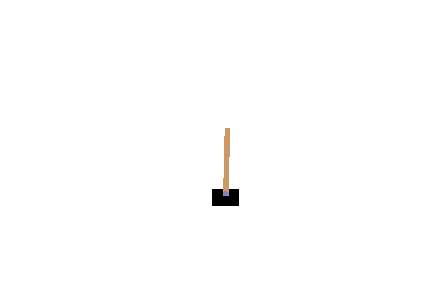
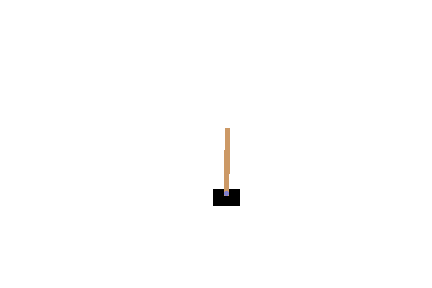
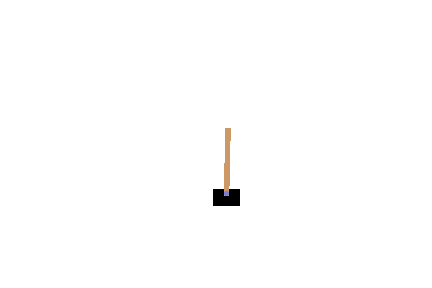
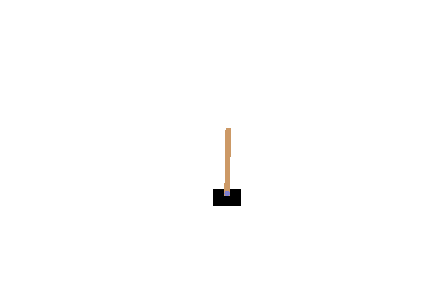
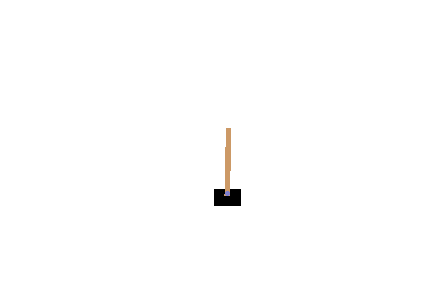
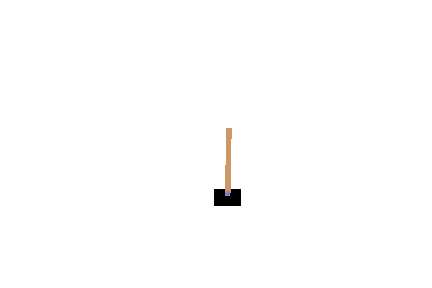
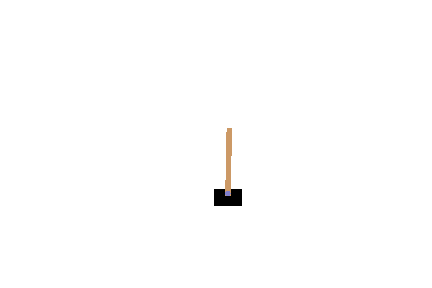
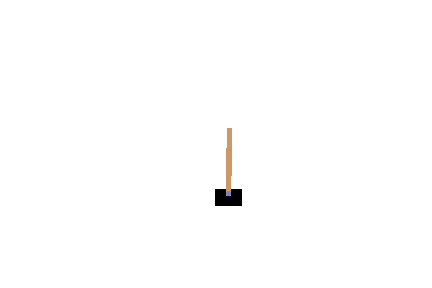
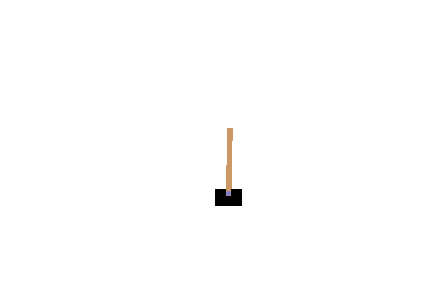
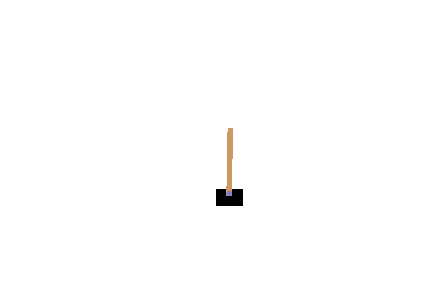
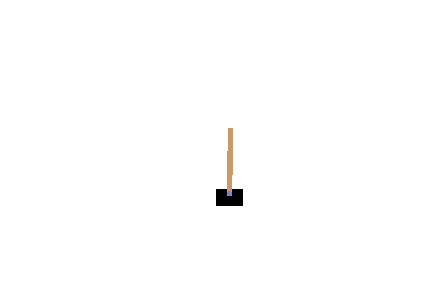
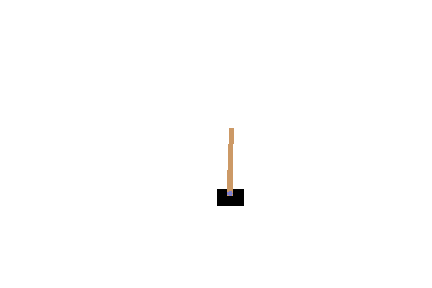
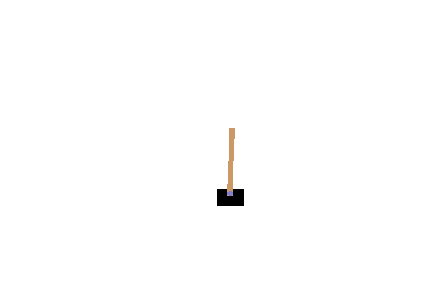
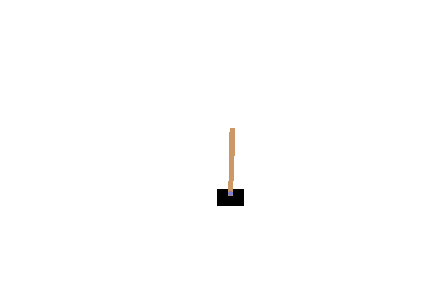
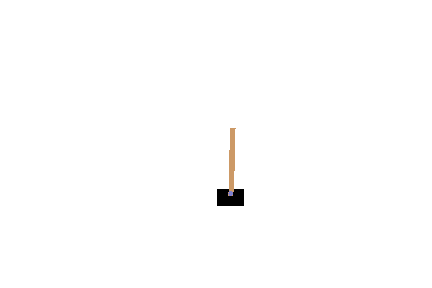
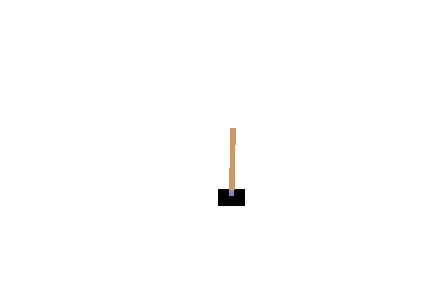
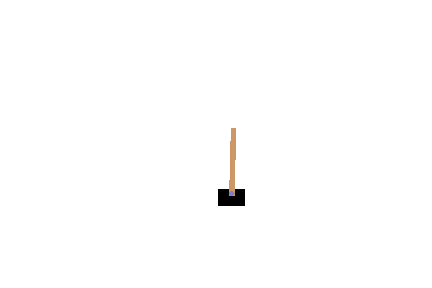
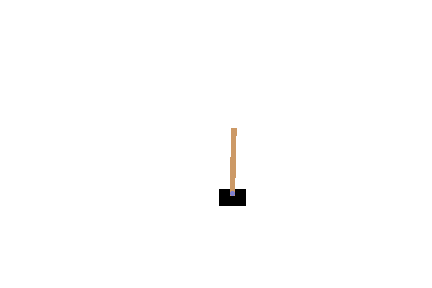
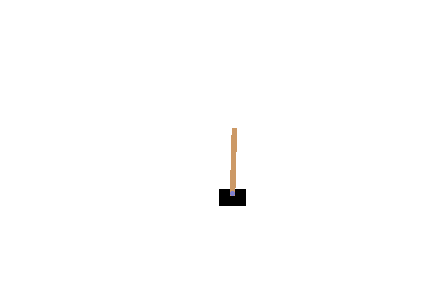
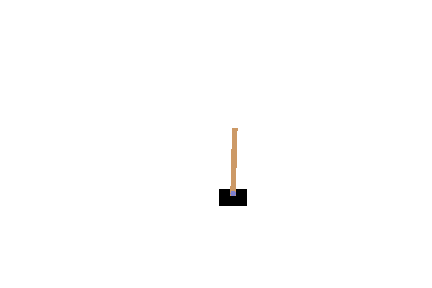
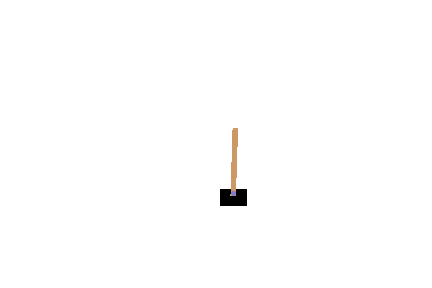
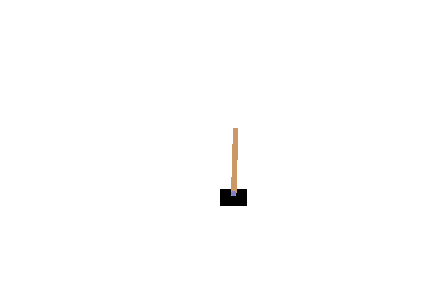
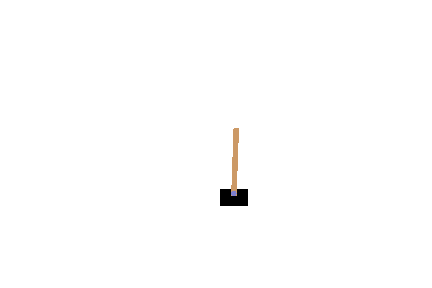
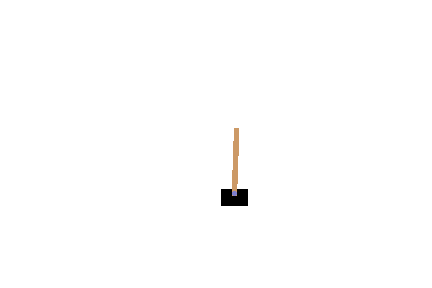
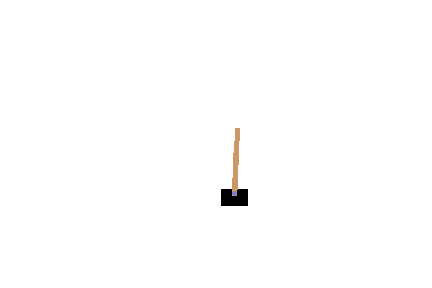
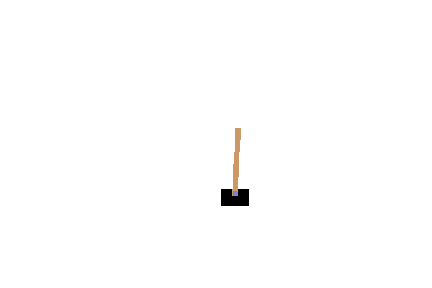
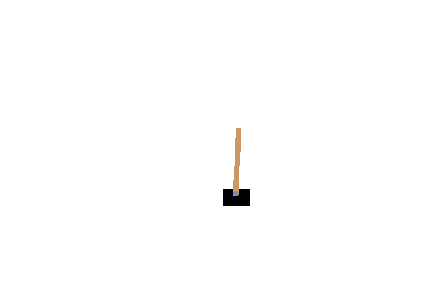
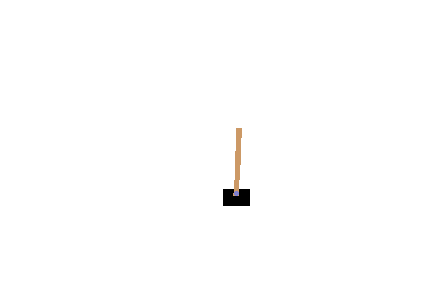
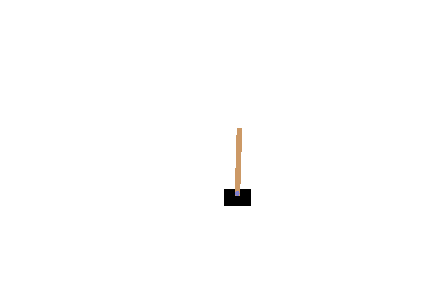
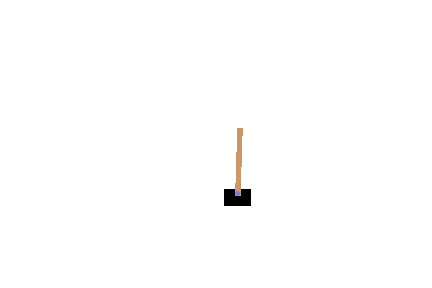
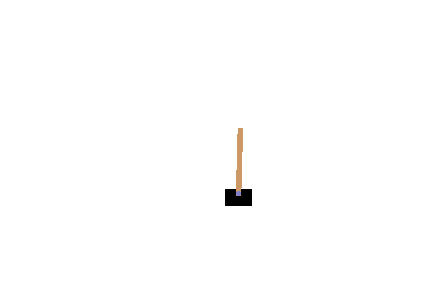
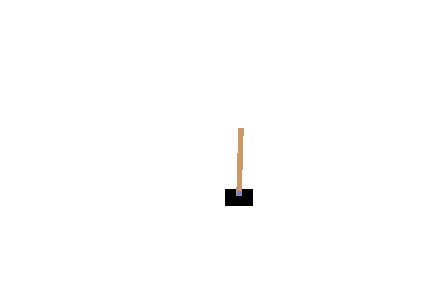
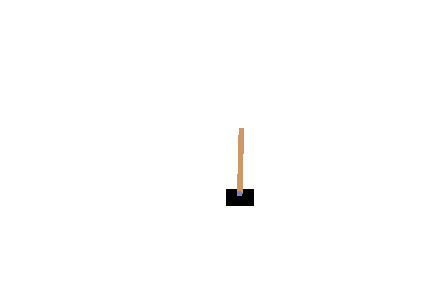
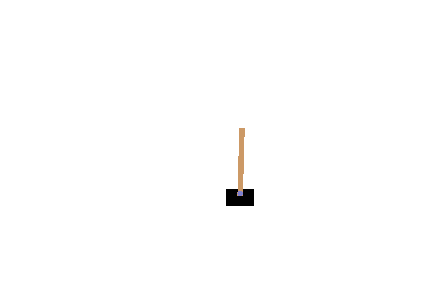
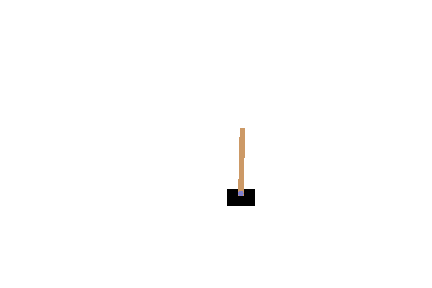
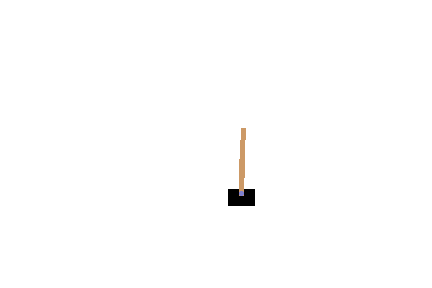
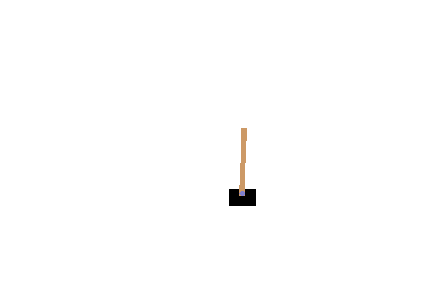
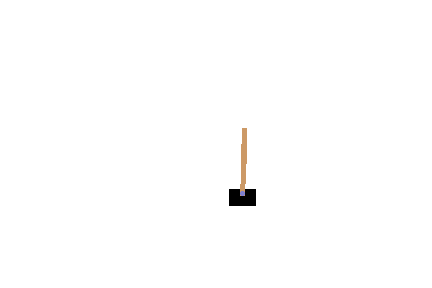
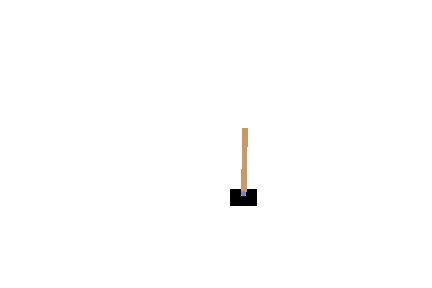
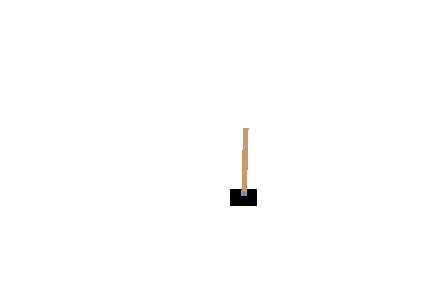
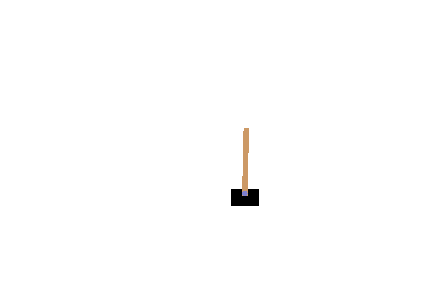
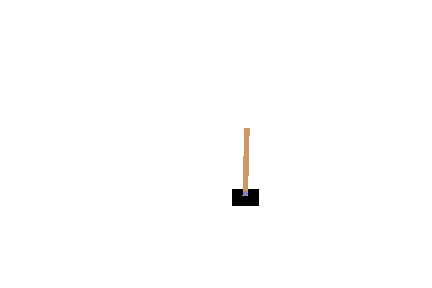
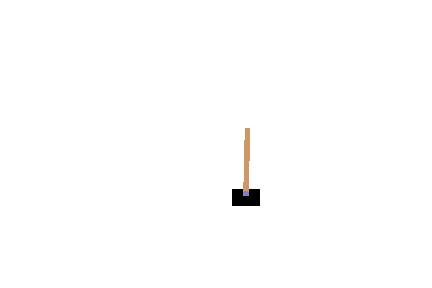
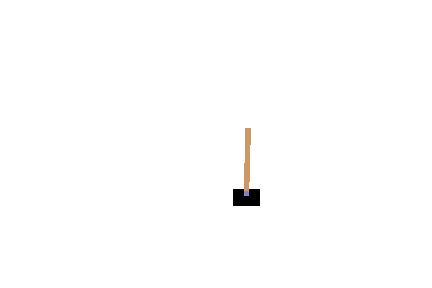
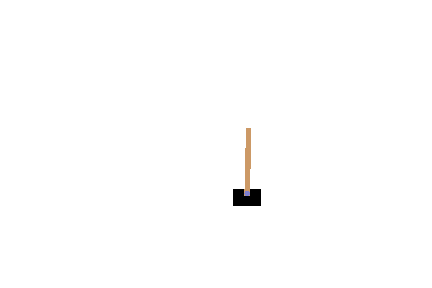
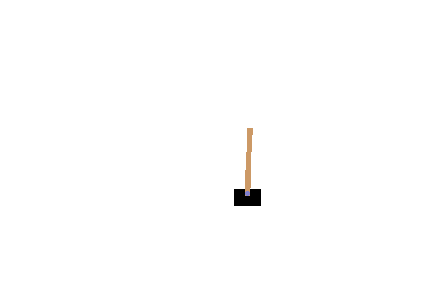
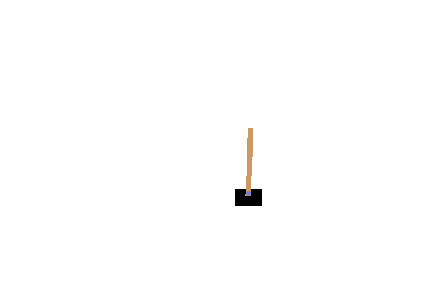
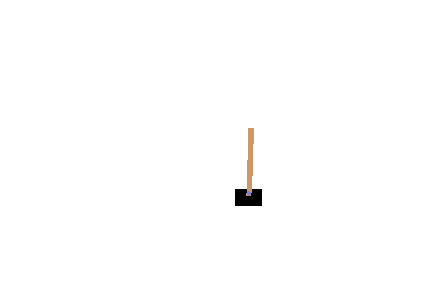
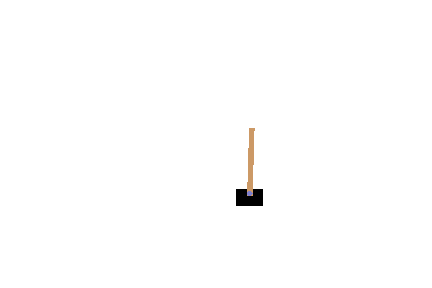
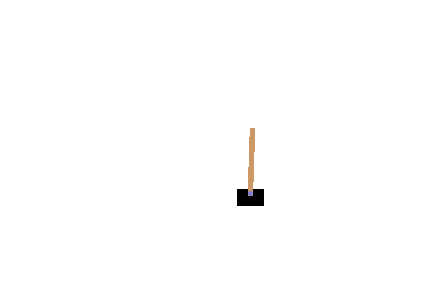
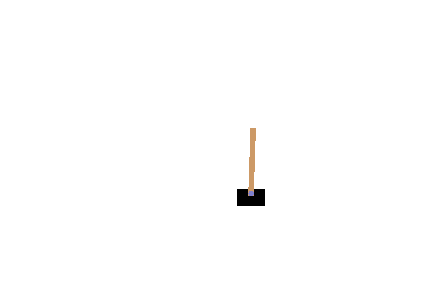
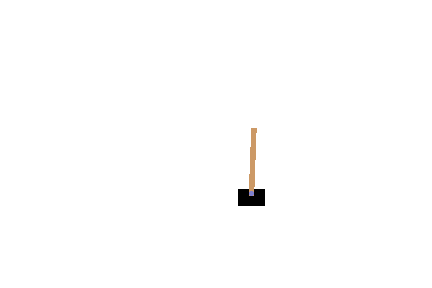
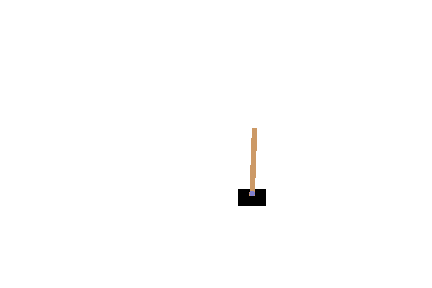
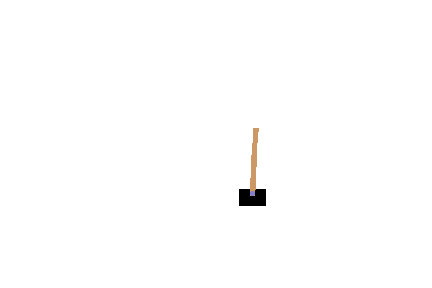
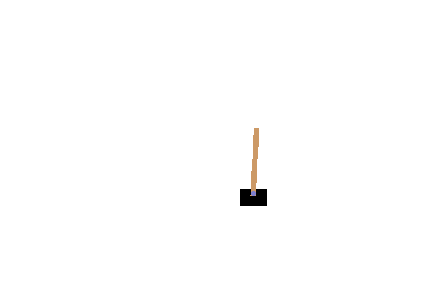
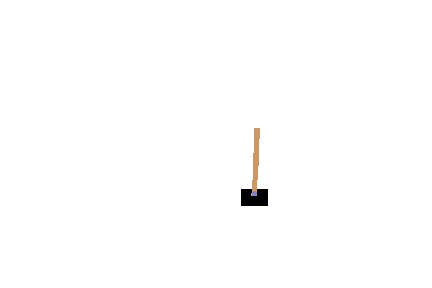
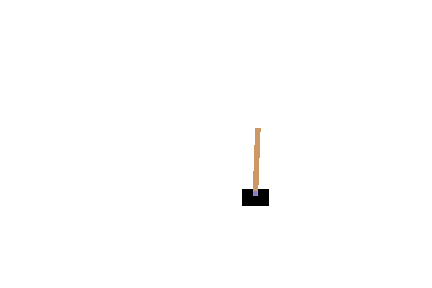
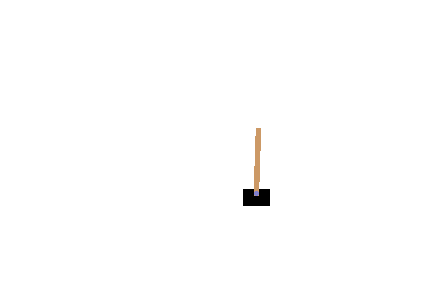
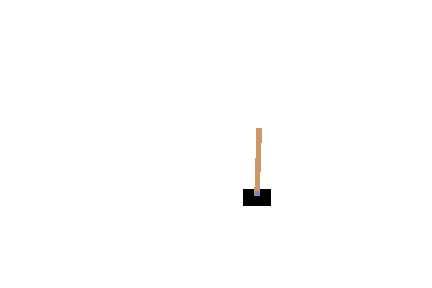
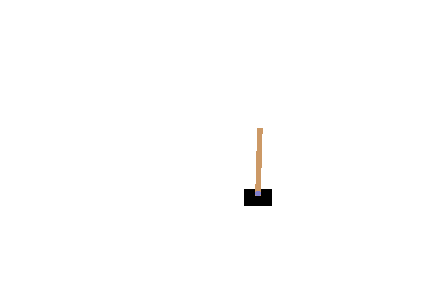
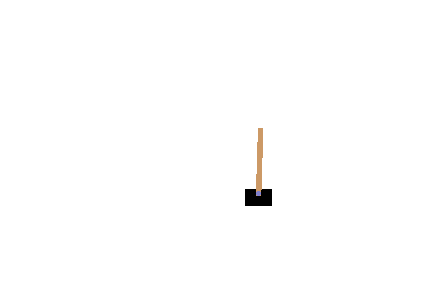
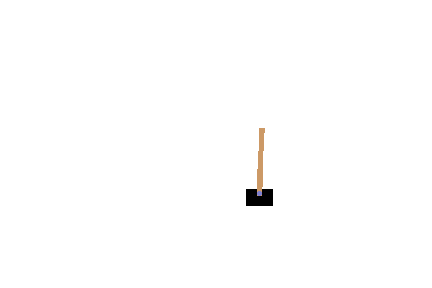
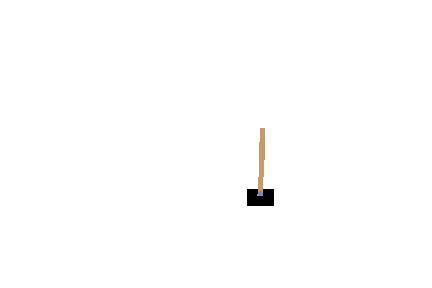
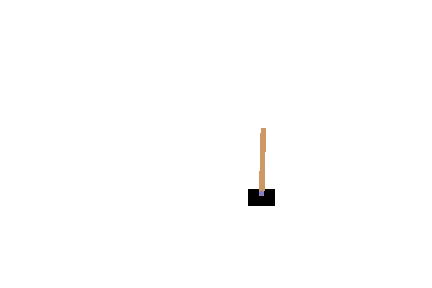
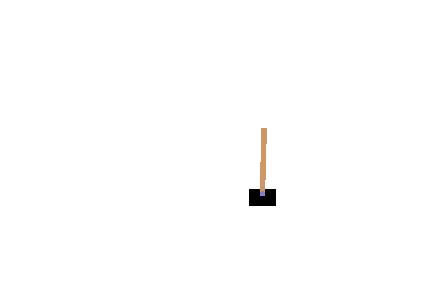
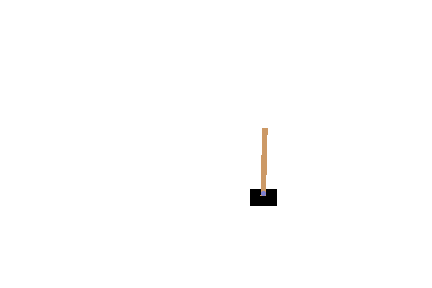
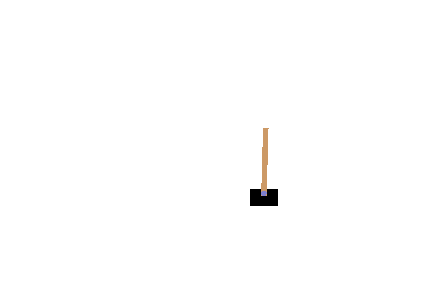
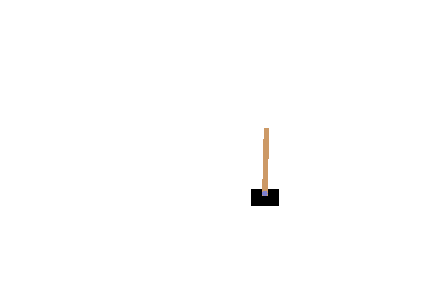
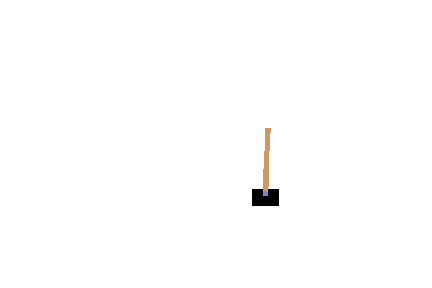
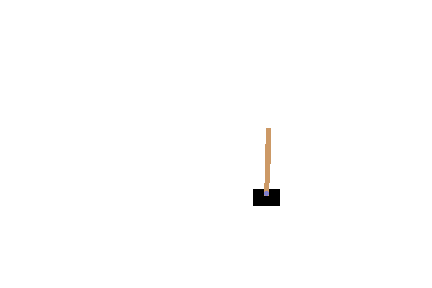
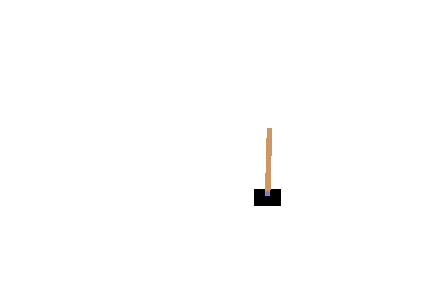
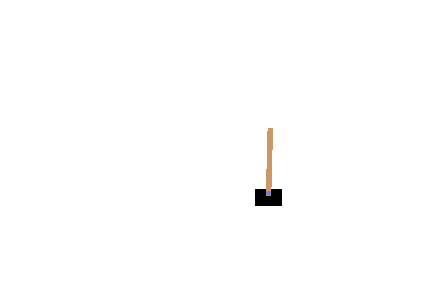
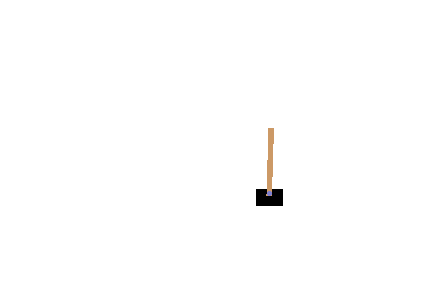
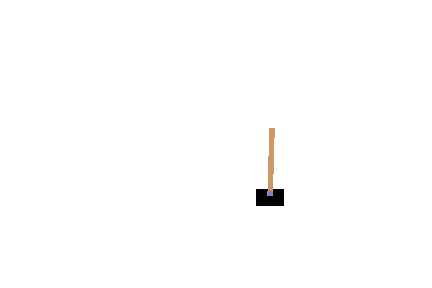
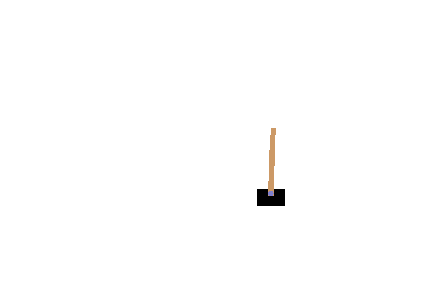
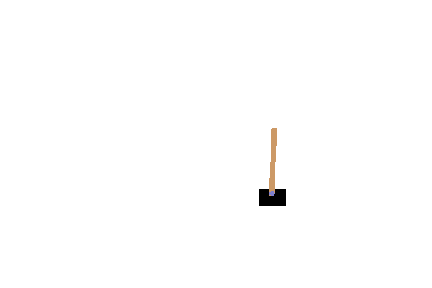
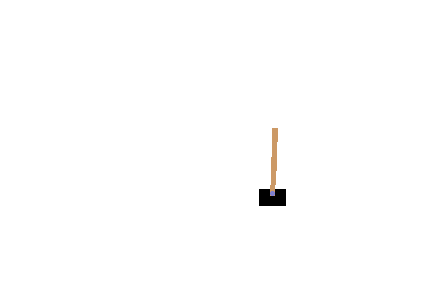
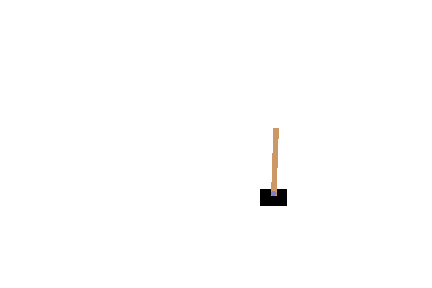
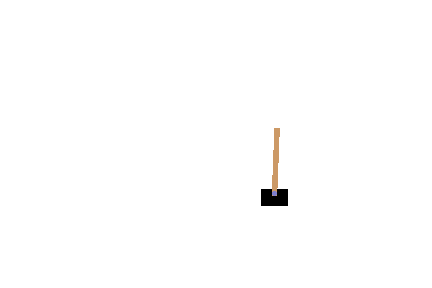
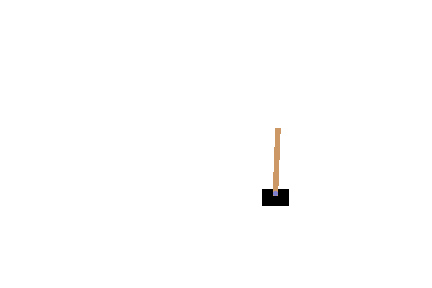
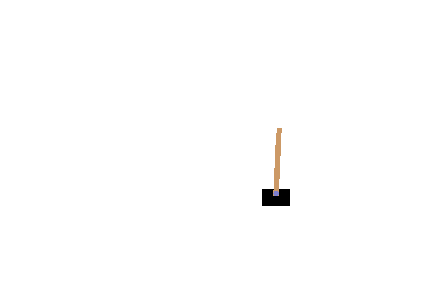
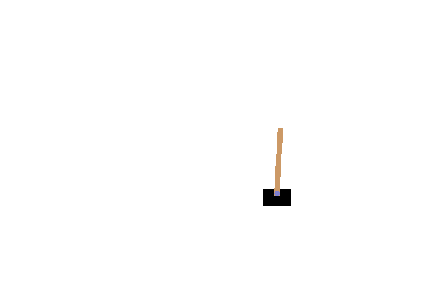
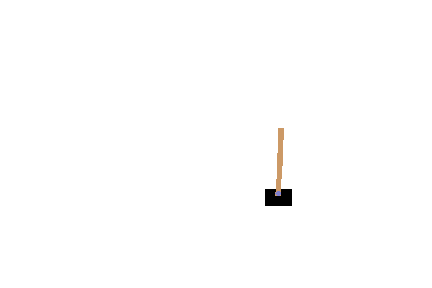
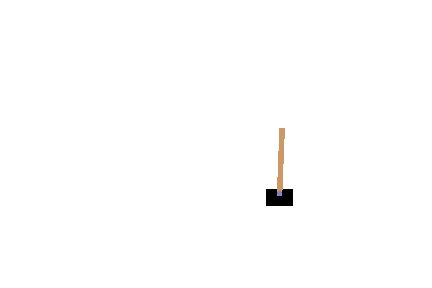
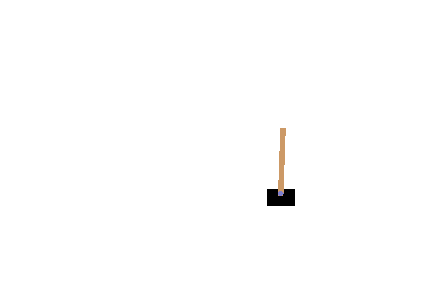
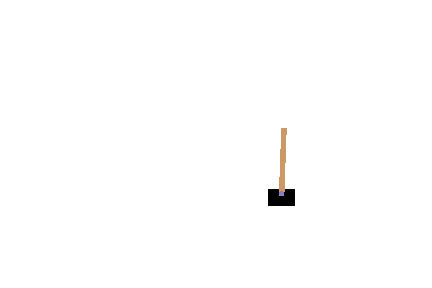
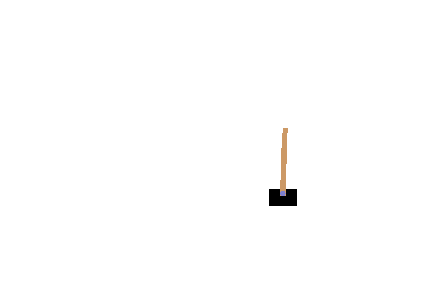
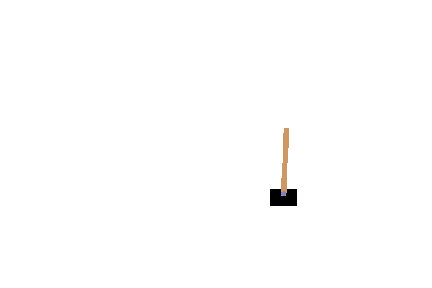
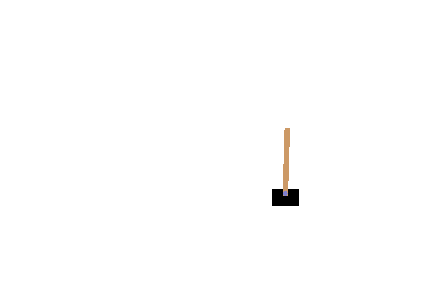
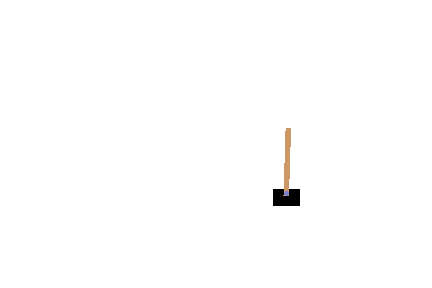
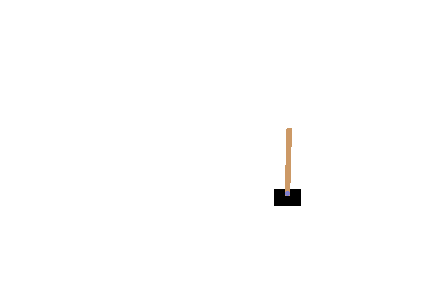
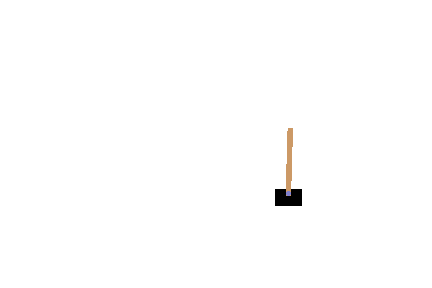
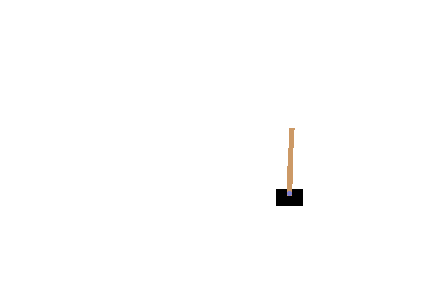
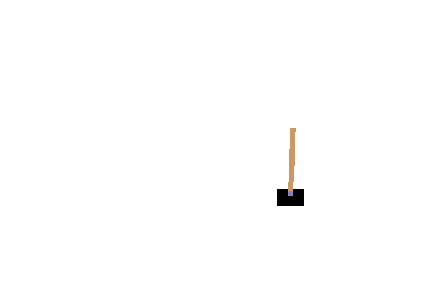
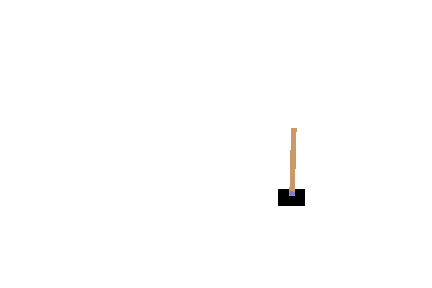
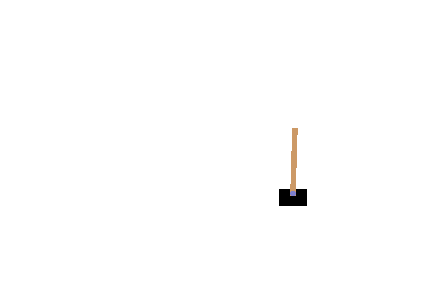
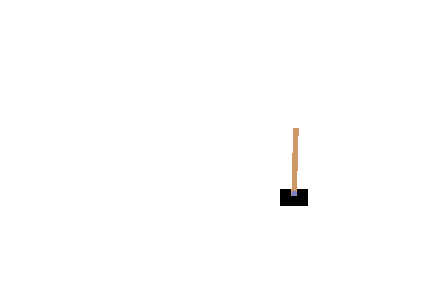
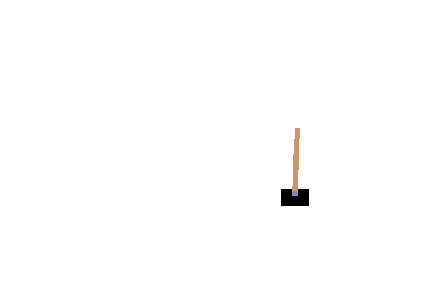
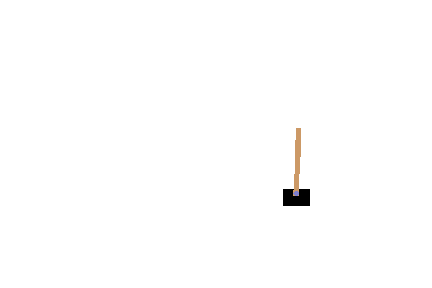
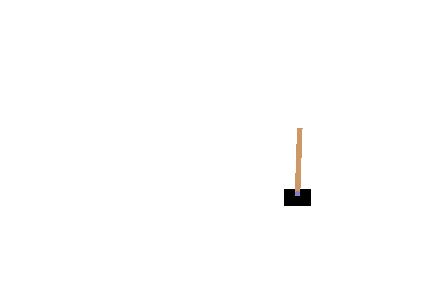
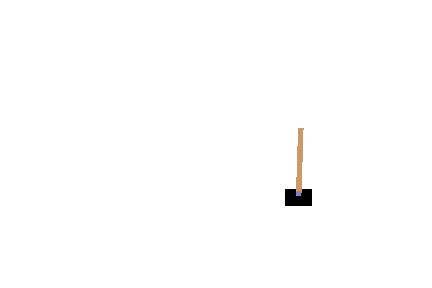
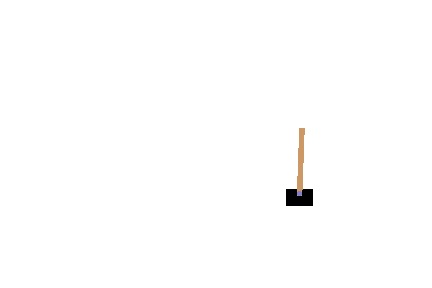
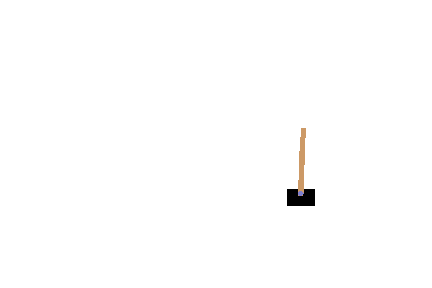
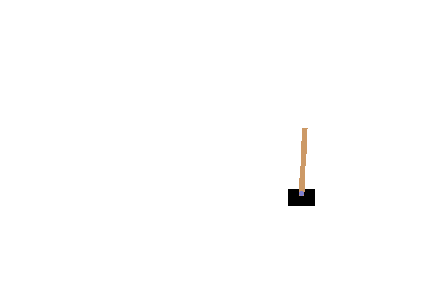
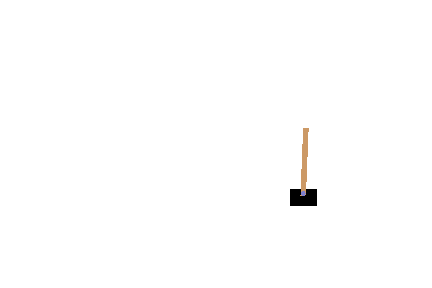
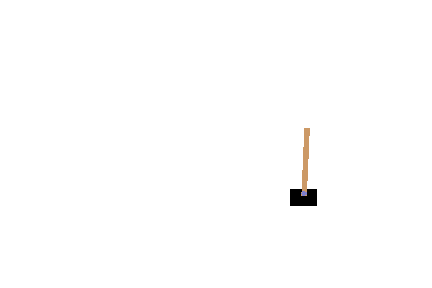
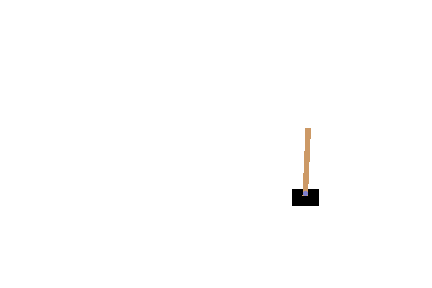
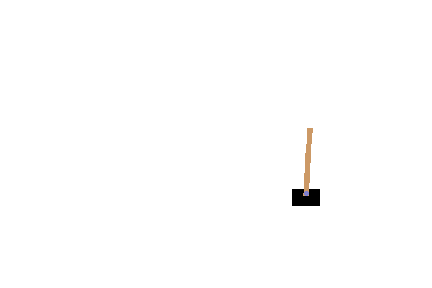
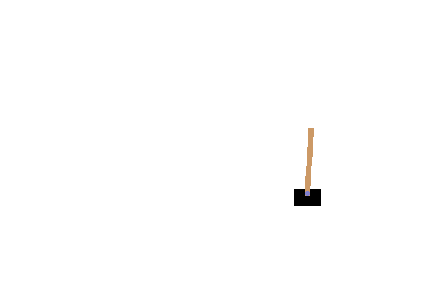
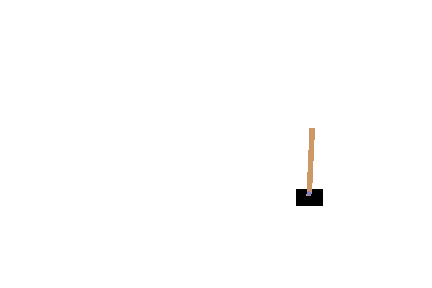
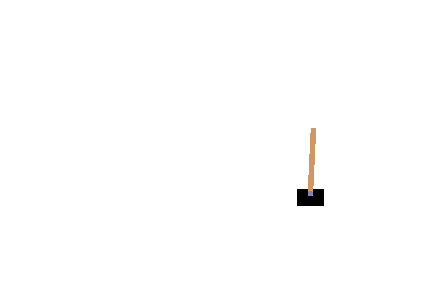
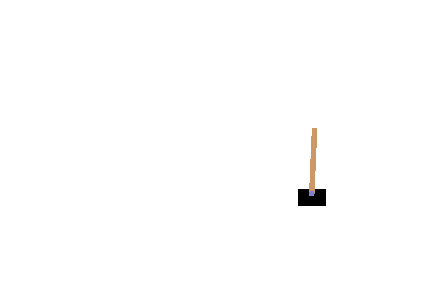
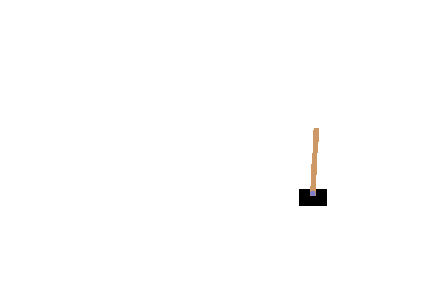
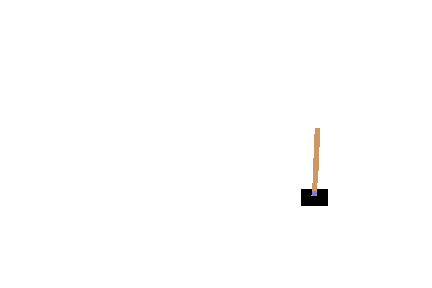
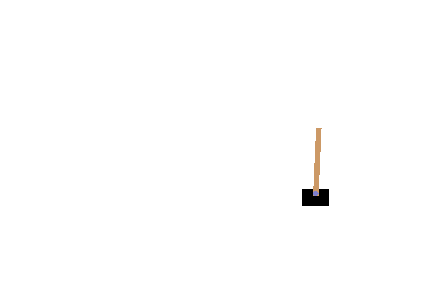
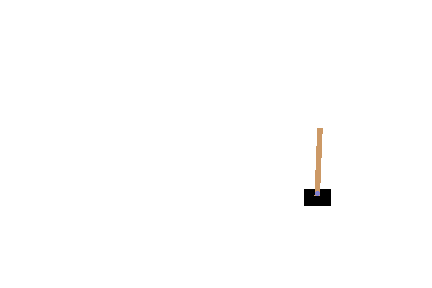
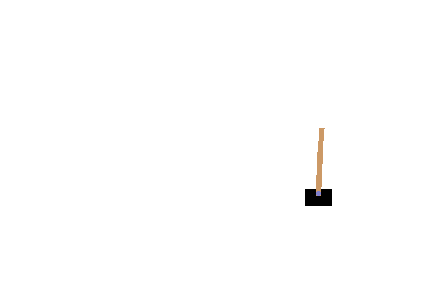
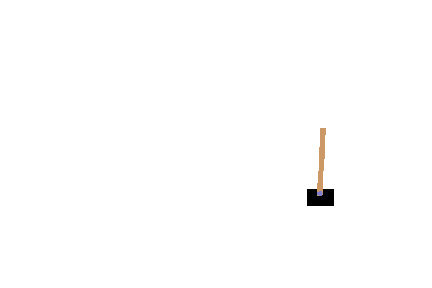
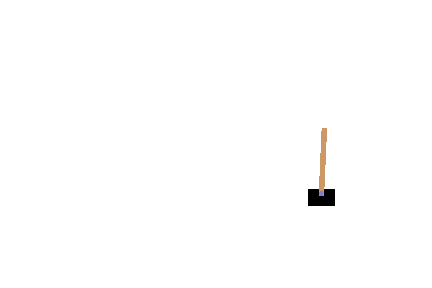
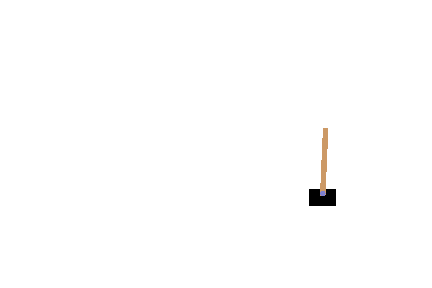

(200.0, 200, array([ 1.50325954,  1.09794888,  0.05143591, -0.06443041]))

In [16]:
simulate(envir, cart, True)

In [32]:
# lest train 3 different versions:
def trainAgent(no_episodes, remember_precision, reward_mod, starting_weight, learn_function):
    envir = gym.make('CartPole-v0')
    cart = cartAgent(starting_weight)
    # cart.angle_treshold = 0.21
    cart.x_velocity_treshold = 1
    rewards = []
    indexes = []
    at_values = []
    for episode in range(no_episodes):
        cumulative_reward, time, observation = simulate(envir, cart)
        rewards.append(cumulative_reward)
        learn_function(cart, cumulative_reward, reward_mod)
        cart.x_velocity_treshold = 1.5
        indexes.append(cart.angle_treshold_index)
        at_values.append(cart.angle_treshold)
        # cart.learn(cumulative_reward, reward_mod)
        vel_tresh, angle_tresh = cart.get_tresholds()
        if episode % remember_precision == 0:
            cart.remember_probs()
    return cart, rewards, indexes, at_values


In [4]:
# cart.print_probs()
#plt.subplots(figsize=(15,10))
#for i in [0,2,4,6,8,9]:
 #   plt.plot(cart.angle_treshold_values, cart.hist_probs[i][1], label ="i=%d"%(100*i,))
#leg = plt.legend(loc='best', ncol=2, mode="expand", shadow=True, fancybox=True)
#leg.get_frame().set_alpha(0.5)
#plt.show()

def plot_agent_history(agent, which,i_multiplyer):
        plt.subplots(figsize=(15,10))
        for i in range(len(agent.hist_probs)):
            plt.plot(agent.angle_treshold_values, agent.hist_probs[i][which], label ="i=%d"%(i_multiplyer*i,))
        leg = plt.legend(loc='best', ncol=2, mode="expand", shadow=True, fancybox=True)
        leg.get_frame().set_alpha(0.5)
        plt.show()
    

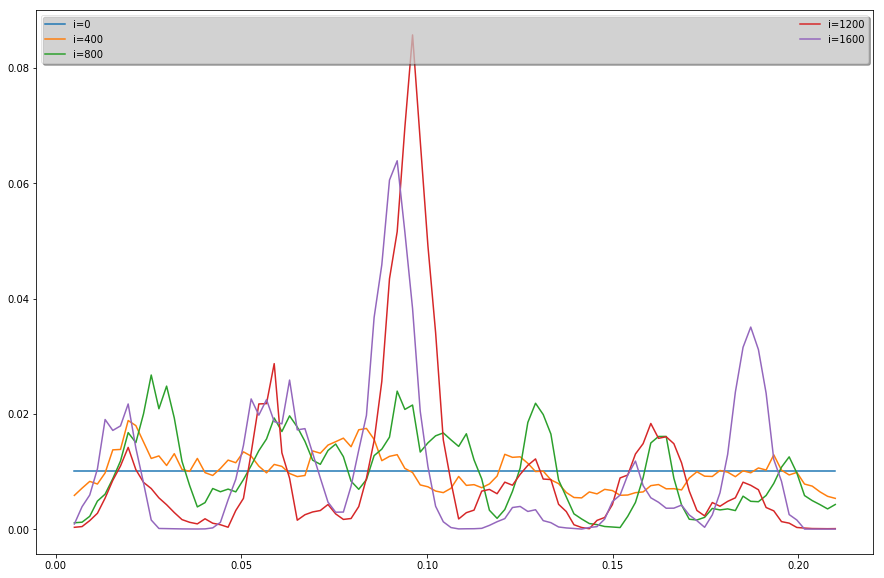

In [41]:
from math import exp
c3, rewards, idx, atv = trainAgent(2000, 400, lambda x: exp(x-199.0)/100.0, 2.0, cartAgent.learn_fuzzy)
plot_agent_history(c3,1,400)

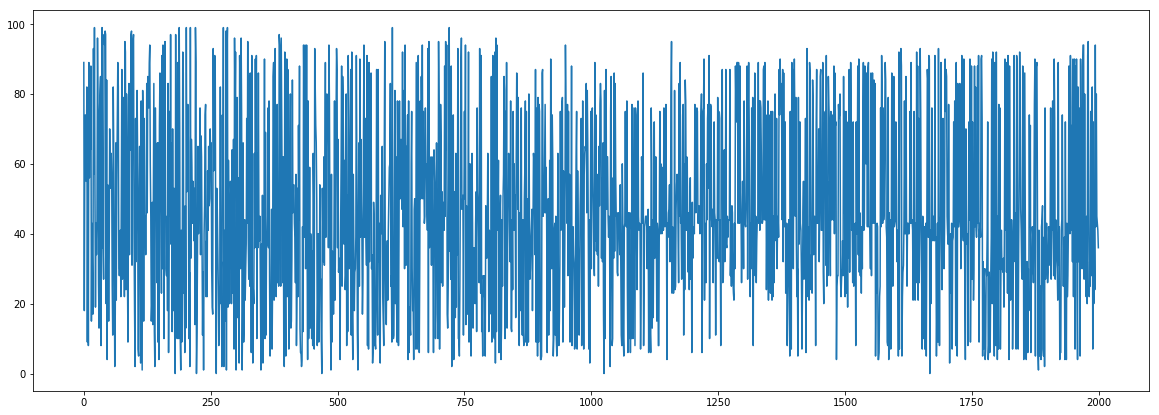

In [42]:
plt.subplots(figsize=(20,7))
plt.plot(range(len(idx)), idx)

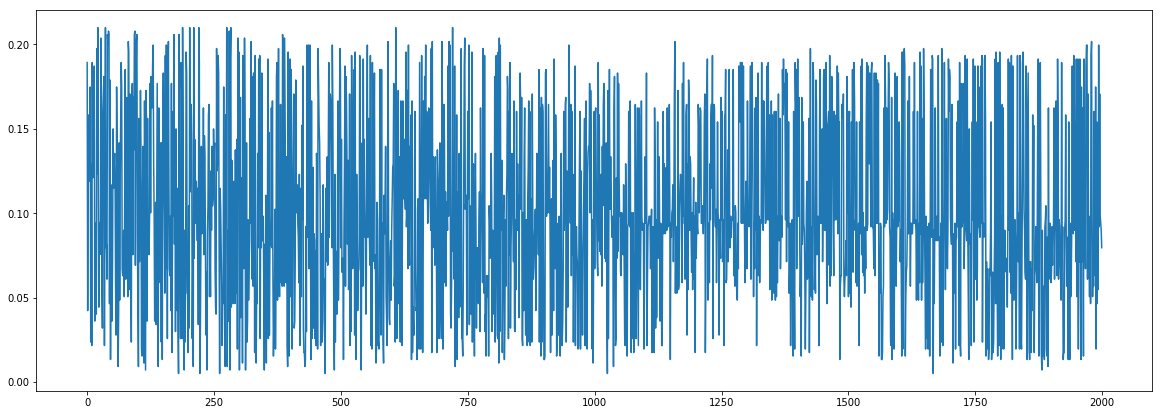

In [43]:
plt.subplots(figsize=(20,7))
plt.plot(range(len(atv)), atv)

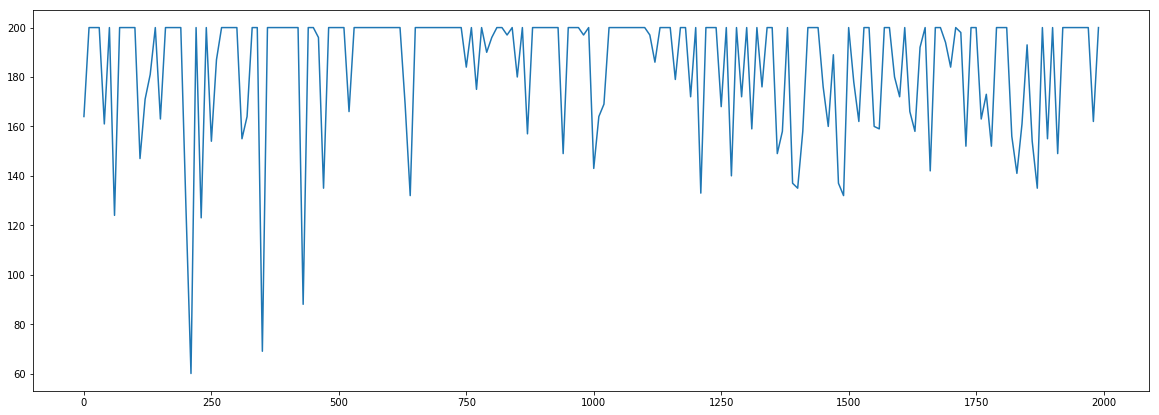

In [44]:
plt.subplots(figsize=(20,7))
plt.plot(range(len(rewards))[0::10], rewards[0::10])

In [191]:
no_episodes = 1000
xs = np.linspace(0.005,0.21,100)
rewards_proc = []
for tr in xs:
    envir = gym.make('CartPole-v0')
    cart = cartAgent(200.0)
    cart.angle_treshold = tr
    cart.x_velocity_treshold = 1
    rewards = 0.0
    for episode in range(no_episodes):
        cumulative_reward, time, observation = simulate(envir, cart)
        rewards += cumulative_reward
    rewards_proc.append(rewards/200.0/no_episodes)

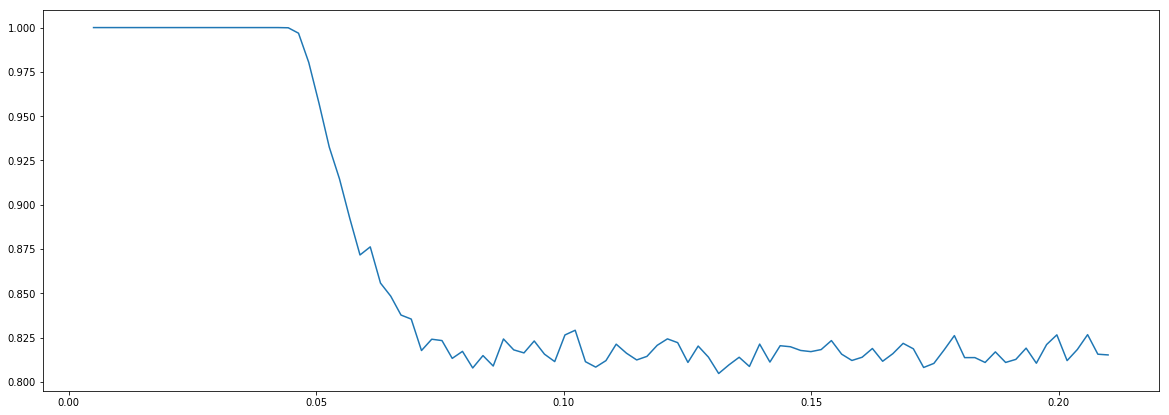

In [192]:
plt.subplots(figsize=(20,7))
plt.plot(xs,rewards_proc)

Check:
    - np.random.choice and the procedure of choosing tresholds - try different sampling